In [2]:
import torch 
import os 
import random 
from utils import sent_to_tensor, read_txt_file,get_vocab_tag
from dataset import Data_class
from model import NER_model
from predict import predict
import matplotlib.pyplot as plt 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

%load_ext autoreload
%autoreload 2

CUDA_LAUNCH_BLOCKING=1

random.seed(32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
vocab_sent = read_txt_file('./data/words.txt')
vocab_tags = read_txt_file('./data/tags.txt')

train_sent = read_txt_file('./data/train/sentences.txt')
train_labels = read_txt_file('./data/train/labels.txt')

val_sent = read_txt_file('./data/val/sentences.txt')
val_labels = read_txt_file('./data/val/labels.txt')

test_sent = read_txt_file('./data/test/sentences.txt')
test_labels = read_txt_file('./data/test/labels.txt')

print('Check the length of sentences/labels')
print(f'Length of training sample: {len(train_sent)} \t Length of training labels: {len(train_labels)}')
print(f'Length of val sample: {len(val_sent)} \t Length of val labels: {len(val_labels)}')
print(f'Length of test sample: {len(test_sent)} \t Length of test labels: {len(test_labels)}')

FileNotFoundError: [Errno 2] No such file or directory: './data/words.txt'

In [3]:
vocab, tag_map = get_vocab_tag(vocab_sent = vocab_sent, vocab_tags = vocab_tags , padding = '<PAD>')

print(f'vocab["the"] = {vocab["the"]} \t vocab["The"] = {vocab["The"]} \t padded_token = {vocab["<PAD>"]}')
print(f'Length of words vocabulary = {len(vocab)}')
print(f'Length of tag vocabulary = {len(tag_map)}')


vocab["the"] = 9 	 vocab["The"] = 61 	 padded_token = 35180
Length of words vocabulary = 35181
Length of tag vocabulary = 18


In [4]:
train_tensors, train_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = train_sent, labels = train_labels)
val_tensors, val_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = val_sent, labels = train_labels)
test_tensors, test_labels_tensor = sent_to_tensor(vocab, tag_map, sentences = test_sent, labels = train_labels)

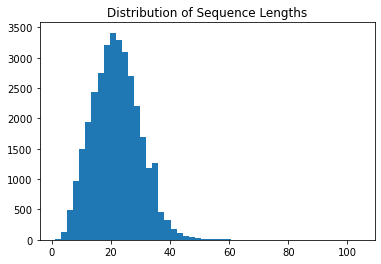

In [10]:
length = [len(s.split(' ')) for s in train_sent]
plt.hist(length, bins = 50)
plt.title('Distribution of Sequence Lengths')
plt.show()

In [6]:
max_length = 50
train_dataset = Data_class(vocab, tag_map, train_sent, train_labels, max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [7]:
model = NER_model( vocab = vocab, tag_map= tag_map, num_layers= 1, d_model = 32).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 10

In [8]:
from tqdm import tqdm
model.train()
for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1} / {num_epochs}')
    running_loss = 0.0 
    acc = 0.0 
    for a in tqdm(train_loader): 
        optimizer.zero_grad()
        sample, labels, mask = a[0].cuda(), a[1].cuda(), a[-1].cuda()
        outputs = model(sample)
        loss = criterion(outputs.transpose(1,2),labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        predictions = torch.argmax(outputs, dim=-1)
        mask = labels != tag_map['<PAD>']
        a = predictions[mask]
        b = labels[mask]
        accuracy = torch.sum(a == b).item() / a.shape[0]
        acc += accuracy
    print(f'Loss = {running_loss/len(train_loader)}')
    print(f'Acc = {acc/len(train_loader)}')
    print('=======================')

Epoch 1 / 10


100%|██████████| 525/525 [00:06<00:00, 85.47it/s] 


Loss = 0.18328095558143798
Acc = 0.9062172243542472
Epoch 2 / 10


100%|██████████| 525/525 [00:05<00:00, 95.60it/s] 


Loss = 0.060751429320800875
Acc = 0.9587937130231661
Epoch 3 / 10


100%|██████████| 525/525 [00:05<00:00, 97.14it/s] 


Loss = 0.04611835491444383
Acc = 0.9670278923301899
Epoch 4 / 10


100%|██████████| 525/525 [00:04<00:00, 105.11it/s]


Loss = 0.039507353348391394
Acc = 0.9710993175467012
Epoch 5 / 10


100%|██████████| 525/525 [00:05<00:00, 103.34it/s]


Loss = 0.03507554371796903
Acc = 0.9736743130459259
Epoch 6 / 10


100%|██████████| 525/525 [00:04<00:00, 109.22it/s]


Loss = 0.03201883153546424
Acc = 0.9757277407692375
Epoch 7 / 10


100%|██████████| 525/525 [00:05<00:00, 101.46it/s]


Loss = 0.02931655660803829
Acc = 0.9773321808577984
Epoch 8 / 10


100%|██████████| 525/525 [00:05<00:00, 97.56it/s] 


Loss = 0.02680129857112964
Acc = 0.9791998930704282
Epoch 9 / 10


100%|██████████| 525/525 [00:05<00:00, 95.58it/s] 


Loss = 0.025122210246821243
Acc = 0.9802933886257826
Epoch 10 / 10


100%|██████████| 525/525 [00:05<00:00, 101.82it/s]

Loss = 0.023483062366999333
Acc = 0.9816575572320733


In [9]:
sentence = input('Enter your sentence to get the result from NER model')
model.eval()
predictions = predict(sentence, model, vocab, tag_map)


(1, 7)
George B-per
California B-geo
January B-tim
